# Genetic Algorithm

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from random import randint

In [2]:
# 데이터 불러오기
df_og = pd.read_csv("Parkinsson disease.csv")  # 파킨슨 질병 데이터셋 사용
df_og.drop(columns = ['name'], axis = 1, inplace=True)
df = df_og.copy()

In [3]:
# 독립 변수 및 종속 변수 할당
Y = df.status
X = df.drop(columns = ['status'], axis = 1)

print(Y.shape, X.shape)

(195,) (195, 22)


In [43]:
class GA:
    def __init__(self, X, Y, pop_size, n_feat, n_parents, mutation_rate, n_gen):
        self.X = X
        self.Y = Y
        self.pop_size = pop_size
        self.n_feat = n_feat
        self.n_parents = n_parents
        self.mutation_rate = mutation_rate
        self.n_gen = n_gen

        from sklearn.model_selection import train_test_split

        self.train_X, self.test_X, self.train_Y, self.test_Y = train_test_split(X, Y, test_size = 0.25, shuffle = True, random_state= 12)


    def initiation_of_pop(self, pop_size):
        population = []
        for i in range(self.pop_size):
            chronosome = np.ones(self.n_feat, dtype = np.bool)
            chronosome[:int(0.5*self.n_feat)] = False
            np.random.shuffle(chronosome)
            population.append(chronosome)
        return population


    def fitness_score(self, population): 
        scores = []
        from sklearn.linear_model import LogisticRegression
        from sklearn.metrics import f1_score
        
        model = LogisticRegression(random_state = 12, max_iter = 100)

        for chronosome in population:
            model.fit(self.train_X.iloc[:,chronosome],self.train_Y)
            preds = model.predict(self.test_X.iloc[:,chronosome])
            scores.append(f1_score(self.test_Y,preds))
        scores, population = np.array(scores), np.array(population)
        inds = np.argsort(scores)

        return list(scores[inds][::-1]), list(population[inds,:][::-1])

    
    def selection(self, pop_after_fit):
        population_nextgen = []
        for i in range(self.n_parents):
            population_nextgen.append(pop_after_fit[i])
        return population_nextgen


    def crossover(self, pop_after_sel):
        pop_nextgen = pop_after_sel

        for i in range(0, len(pop_after_sel), 2):
            new_par = []
            child_1, child_2 = pop_nextgen[i], pop_nextgen[i+1]
            new_par = np.concatenate((child_1[:len(child_1)//2], child_2[len(child_1)//2:]))
            pop_nextgen.append(new_par)
        return pop_nextgen


    def mutation(self, pop_after_cross):
        mutation_range = int(self.mutation_rate * self.n_feat)
        pop_next_gen = []
        
        for n in range(0, len(pop_after_cross)):
            chrono = pop_after_cross[n]
            rand_posi = []

            for _ in range(0, mutation_range):
                pos = randint(0, self.n_feat - 1)
                rand_posi.append(pos)

            for i in rand_posi:
                chrono[i] = not chrono[i]

            pop_next_gen.append(chrono)
        return pop_next_gen    


    def generations(self):
        best_chrono = []
        best_score = []
        population_nextgen = self.initiation_of_pop(self.pop_size) 

        for i in range(self.n_gen):
            scores, pop_after_fit = self.fitness_score(population_nextgen)

            if i == 0:
                print(f'Best score in first generation : {scores[:1]}')

            if i == self.n_gen - 1:
                print(f'Best score in Last generation ({i+1}-th generation): {scores[:1]}')

            pop_after_sel = self.selection(pop_after_fit) 
            pop_after_cross = self.crossover(pop_after_sel)
            population_nextgen = self.mutation(pop_after_cross) 
            best_chrono.append(pop_after_fit[0])
            best_score.append(scores[0])

        return best_chrono, best_score


    def plot_gen_score(self, score):
        gen = np.array(range(self.n_gen)) + 1
        plt.figure(figsize = (25,4))
        ax = sns.pointplot(x = gen, y = score, color = 'b')
        ax.set(xlabel = "Num of Generation", ylabel = "F1-score")
        plt.xticks(rotation = 45)
        ax.set(ylim = (0.5 , 1))

In [37]:
import warnings
warnings.filterwarnings('ignore')

GA_test = GA(X = X, Y = Y, pop_size = 40, n_feat = X.shape[1], n_parents = 5, mutation_rate = .1, n_gen = 100)
best_chrono, best_score = GA_test.generations()

Best score in first generation : [0.923076923076923]
Best score in Last generation (100-th generation): [0.923076923076923]


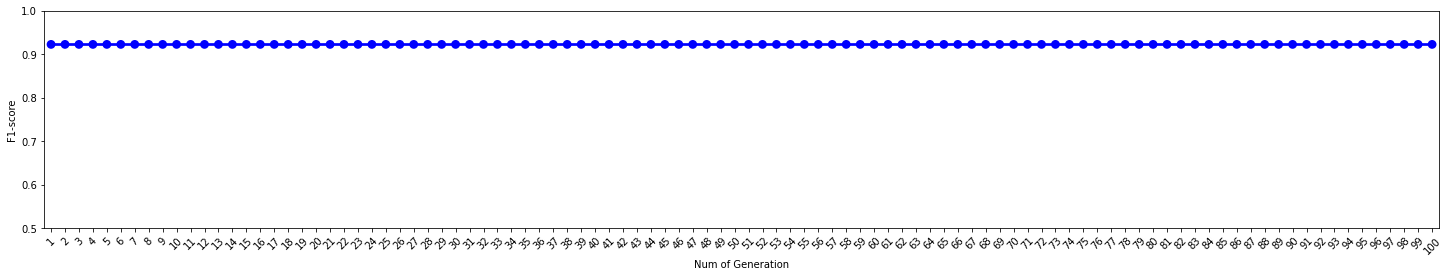

In [44]:
GA_test.plot_gen_score(score = best_score)